In [1]:
import pandas as pd
import scipy.io
import numpy as np
from scipy.spatial.distance import pdist, squareform
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
import time
rand_state = 42
tf.random.set_seed(rand_state)
np.random.seed(rand_state)

import warnings
warnings.simplefilter('ignore')

2023-06-13 18:02:53.755011: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 18:02:54.455771: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Outline  

1. Introduction
2. Data
  * Feature Engineering
3. Visualization
  * Kernel PCA
  * t-SNE
4. Classification
  * SVM
  * Classification metrics
5. Regression
  * XGBoost
  * Deep Learning
    * MLP
    * CNN
6. Conclusions



# Introduction  

Research and development (R&D) costs for US based pharmaceutical companies have risen 43.9% just over the last 5 years ([source](https://www.statista.com/statistics/265085/research-and-development-expenditure-us-pharmaceutical-industry/)). R&D spending has increased by 27% since 2010 and is projected to increase by another 23.6% over the next 5 years; R&D accounts for roughly 21% of all pharmaceutical sales, this pipeline can be summarized as so:  

  1. Pre-clinical  
  2. Phase 1 clinical trials  
  3. Phase II  
  4. Phase III  
  5. Pre-registration  
  6. Registered  
  7. Launched  
  8. Suspended  
  
The most resources (by far) are spent in the pre-clinical stage ([source](https://www.statista.com/statistics/791288/r-and-d-pipeline-drugs-worldwide-by-phase-development/)), with drug discovery being one of the initial steps in this process. Drug discovery is the process by which new candidate medications are discovered. In classical pharmacology, chemical libraries of synthetic small molecules, natural products or extracts are utilized in combination with in-vitro studies to identify substances that have a desirable therapeutic effect. 

Since the sequencing of the human genome, it has become common practice to use high throughput screening of large compounds libraries against isolated biological targets which are hypothesized to be disease modifying in a process known as reverse pharmacology. The candidate drugs are then tested for efficacy in-vivo. Various chemical properties, such as ADME (absorption, distribution, metabolism and excretion) as well as atomization energy have been shown to play a crucial role in the screening of such compounds, and that is where machine learning can help! The accurate prediction of molecular energetics in chemical compound space is a crucial ingredient for rational compound design.  

Currently only high-level quantum-chemistry calculations, which can take days per molecule depending on property and system, yield the desired “chemical
accuracy” of 1 kcal/mol required for computational molecular design. Here, I am proposing a less expensive machine learning approach to predicting this the quantum mechanical property of atomization energy. To accomplish this objective, I will engineer features to work well with a gradient boosting regression model, support vector machine classification model, as well as a multilayer perceptron network and a convolutional neural network. 

# Data  

I am using the QM7 dataset, which is a subset of GDB-13 (a database of nearly 1 billion stable and synthetically accessible organic molecules) containing up to 7 heavy atoms C, N, O, and S. The 3D Cartesian coordinates of the most stable conformations and their atomization energies were determined using ab-initio density functional theory (PBE0/tier2 basis set). This dataset also provided Coulomb matrices as calculated in [Rupp et al. PRL, 2012]:  
  * $C_{i,i} = 0.5 \cdot Z^2.4$  
  * $C_{i,j} = Z_i \cdot \frac{Z_j}{|(R_i−R_j)|}$ 
  * $Z_i$ - nuclear charge of atom i  
  * $R_i$ - cartesian coordinates of atom i  

The data file (.mat format, we recommend using `scipy.io.loadmat` for python users) contains five arrays:  
  * "X" - (7165 x 23 x 23), Coulomb matrices  
  * "T" - (7165), atomization energies (unit: kcal/mol)  
  * "P" - (5 x 1433), cross-validation splits as used in [Montavon et al. NIPS, 2012]  
  * "Z" - (7165 x 23), atomic charges  
  * "R" - (7165 x 23 x 3), cartesian coordinate (unit: Bohr) of each atom in the molecules   


## Feature Engineering  

The data is stored in a MATLAB file, so we read that using SciPy. For the regression models, I take the upper triangle of each Coulomb Matrix (with diagonal) and unroll it so each has the shape: (1, num_atoms*(num_atoms+1)/2). I then compute the pairwise distance matrix and from this get the corresponding Eigenvalues and [Eigenvector Centralities](https://en.wikipedia.org/wiki/Eigenvector_centrality). I am attempting to estimate the influence one particular atom plays on the entire molecule; typically, this is performed on an adjacency matrix (graph), however, I am assuming the connectivity (bonds) are not known upfront (can be accurately predicted via Monte Carlo simulations).  

## Previous work  
This is an extension to some earlier research that I previously [conducted](https://www.kaggle.com/mjmurphy28/predicting-ground-state-energy). That study (and therefore this one also) is primarily based off two previous studies: a 2016 publication by [B. Himmetoglu](https://arxiv.org/abs/1609.07124) and a team of researchers at [Stanford](http://moleculenet.ai). The earlier work by Himmetoglu reported a RMSE of 38.75 kcal/mol on the train set and 36.83 on the test set. I was not able to find the full results from the team at Stanford, however, on their [site](http://moleculenet.ai/latest-results) they list a MAE of 8.56 (I am assuming that this metric comes from evaluating their TensorFlow regression model on the test set).

In [4]:
qm7 = scipy.io.loadmat('../qm7.mat')
# compute the Eigenvectors of the pairwise distance matrix?
R = qm7['R']

y = np.transpose(qm7['T']).reshape((7165,))
y_scaling_factor = 2000.
y_scaled = y / y_scaling_factor

# k=0 # 0 = include diagnol, 1 = do not include diagnol

num_atoms = 23
iu = np.triu_indices(num_atoms,k=0) 
iu_dist = np.triu_indices(num_atoms,k=1) # for the pairwise distance matrix, all diagonol entries will be 0 


CM = np.zeros((qm7['X'].shape[0], num_atoms*(num_atoms+1)//2), dtype=float)
eigs = np.zeros((qm7['X'].shape[0], num_atoms), dtype=float)
centralities = np.zeros((qm7['X'].shape[0], num_atoms), dtype=float)
interatomic_dist = np.zeros((qm7['X'].shape[0], ((num_atoms*num_atoms)-num_atoms)//2), dtype=float) 

verbose=True

for i, cm in enumerate(qm7['X']):
    coulomb_vector = cm[i]
    # Sort elements by decreasing order
    shuffle = np.argsort(-coulomb_vector)
    CM[i] = coulomb_vector[shuffle]
    dist = squareform(pdist(R[i]))
    # we can extract the upper triangle of the distance matri: return vector of dimension (1,num_atoms)
    dist_vector = dist[iu_dist]
    shuffle = np.argsort(-dist_vector)
    interatomic_dist[i] = dist_vector[shuffle]
    
    w,v = np.linalg.eig((dist))
    eigs[i] = w[np.argsort(-w)]
    centralities[i] = np.array(list(nx.eigenvector_centrality(nx.Graph(dist)).values()))
    
    if verbose and i % 500 == 0:
        print("Processed {} molecules".format(i))
    
X = np.concatenate((CM, eigs, centralities, interatomic_dist), axis=1)
X.shape

Processed 0 molecules
Processed 500 molecules
Processed 1000 molecules
Processed 1500 molecules
Processed 2000 molecules
Processed 2500 molecules
Processed 3000 molecules
Processed 3500 molecules
Processed 4000 molecules
Processed 4500 molecules
Processed 5000 molecules
Processed 5500 molecules
Processed 6000 molecules
Processed 6500 molecules
Processed 7000 molecules


(7165, 575)

# Visualization

In [5]:
def mean_dist(x):
    x[x == 0] = np.nan
    return np.nanmean(x, axis=0)



mean_dists = np.apply_along_axis(mean_dist, axis=1, arr=interatomic_dist)

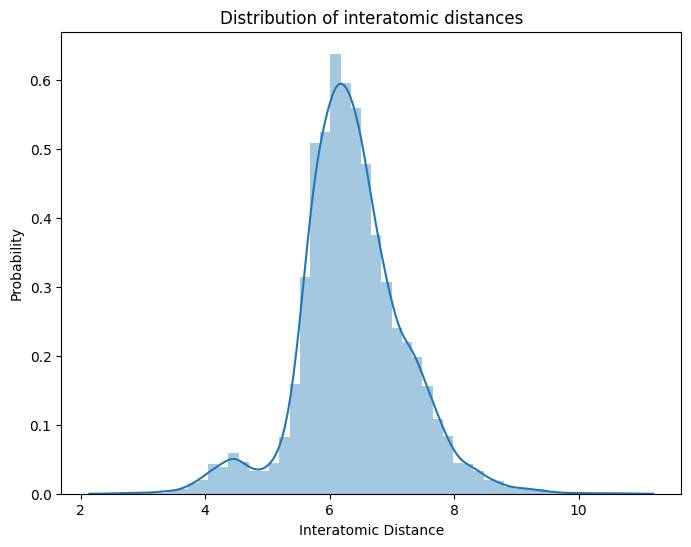

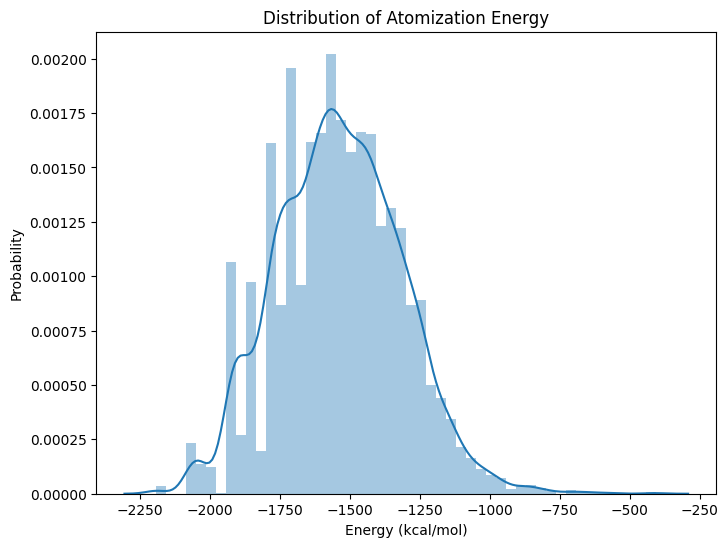

In [6]:
plt.figure(figsize=(8,6))
sns.distplot(mean_dists)
plt.xlabel('Interatomic Distance')
plt.ylabel('Probability')
plt.title('Distribution of interatomic distances')
plt.show()

plt.figure(figsize=(8,6))
sns.distplot(y)
plt.xlabel('Energy (kcal/mol)')
plt.ylabel('Probability')
plt.title('Distribution of Atomization Energy')
plt.show()

Let us try to visualize just the **Coulomb Matrices**.

--- 14.440246105194092 seconds ---
Variance Explained:  1.0


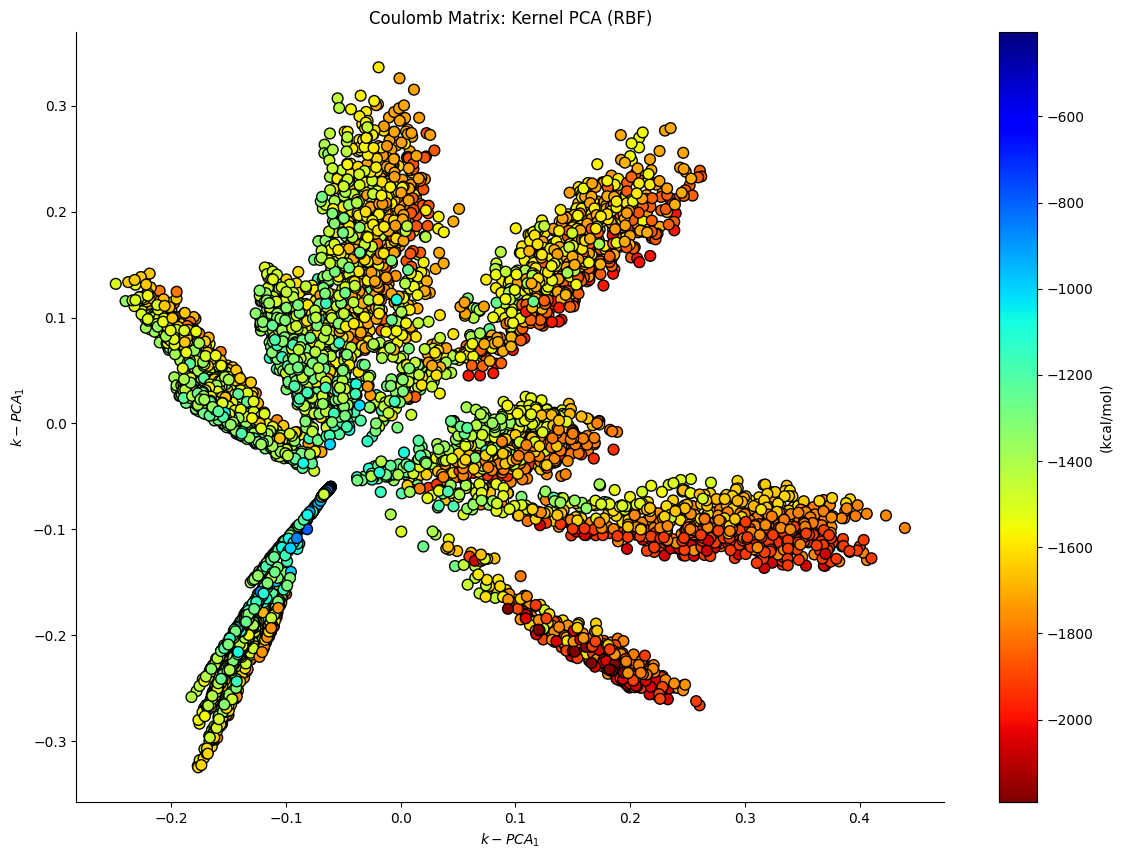

In [7]:
from sklearn.decomposition import KernelPCA
from matplotlib import cm

# scale Coulomb Matrices, divide by 370
CM = qm7['X'].reshape((7165, 529))


start_time = time.time()
kpca = KernelPCA(n_components=2, kernel="rbf")
CM_reduced = kpca.fit_transform(CM)
print("--- %s seconds ---" % (time.time() - start_time))
explained_variance = np.var(CM_reduced, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
print("Variance Explained: ", np.sum(explained_variance_ratio))

fig = plt.figure(figsize=(14,10))
ax  = fig.add_subplot(111)

scatter = ax.scatter(CM_reduced[:,0], CM_reduced[:,1], c=y, s=60, edgecolors='black', cmap=cm.jet_r)
colorbar = fig.colorbar(scatter, ax=ax, label = "(kcal/mol)")
plt.xlabel(r'$k-PCA_1$')
plt.ylabel(r'$k-PCA_1$')
plt.title("Coulomb Matrix: Kernel PCA (RBF)")
sns.despine()
plt.show()

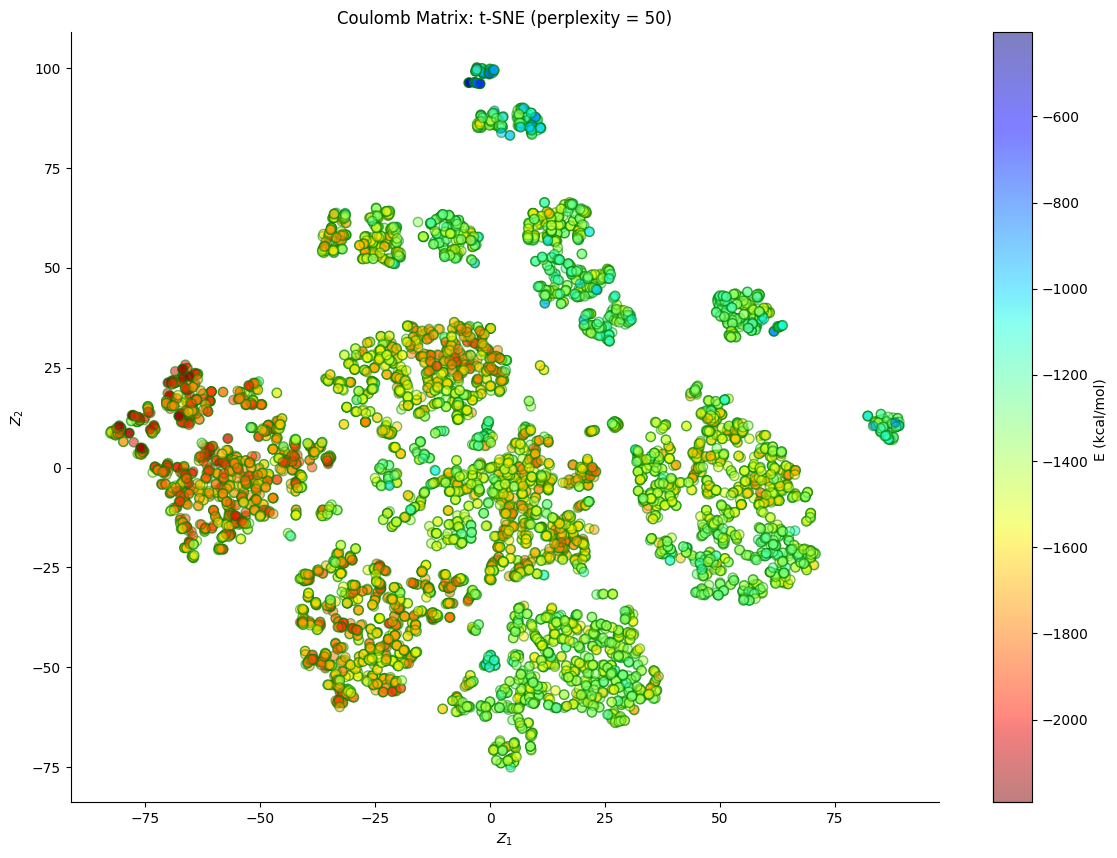

In [8]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=rand_state, perplexity=50)
X_tsne = tsne.fit_transform(CM)

fig = plt.figure(figsize=(14,10))
ax  = fig.add_subplot(111)

scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], c=y, s=45, edgecolors='green', cmap=cm.jet_r, alpha=0.5)
colorbar = fig.colorbar(scatter, ax=ax, label = "E (kcal/mol) ")
plt.xlabel(r'$Z_1$')
plt.ylabel(r'$Z_2$')
plt.title('Coulomb Matrix: t-SNE (perplexity = 50)')
sns.despine()
plt.show()

Now let us add our other features and see how this changes (visually): specifically, we unroll and sort the Coulmb Matrices, add the Eigenvectors and centralities.

--- 18.267154932022095 seconds ---
Variance Explained:  1.0


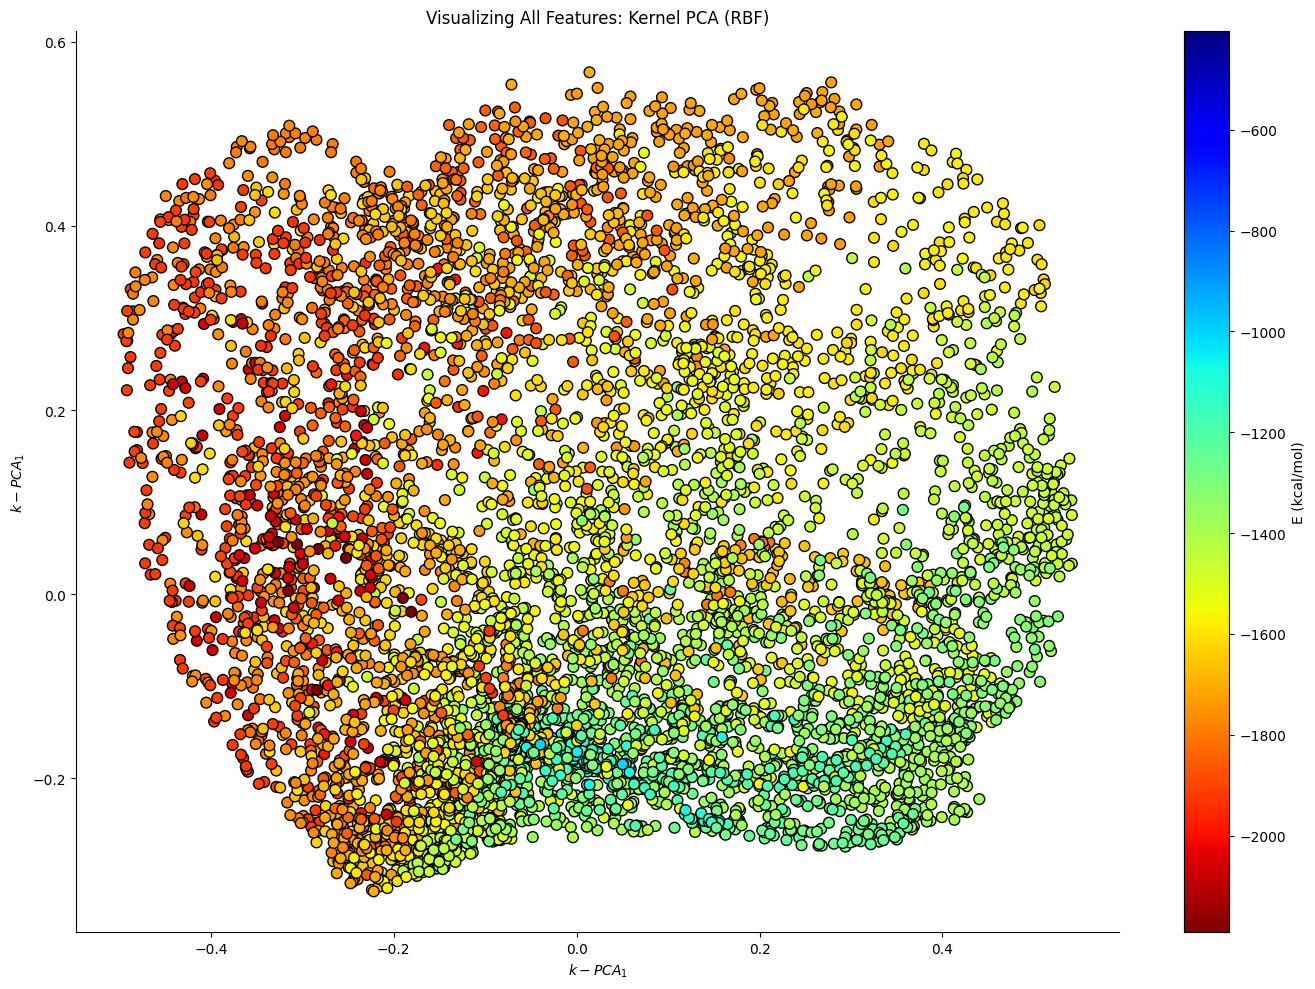

In [9]:
start_time = time.time()
kpca = KernelPCA(n_components=2, kernel="rbf")
X_reduced = kpca.fit_transform(X)
print("--- %s seconds ---" % (time.time() - start_time))
explained_variance = np.var(X_reduced, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
print("Variance Explained: ", np.sum(explained_variance_ratio))

fig = plt.figure(figsize=(14,10))
ax  = fig.add_subplot(111)

scatter = ax.scatter(X_reduced[:,0], X_reduced[:,1], c=y, s=60, edgecolors='black', cmap=cm.jet_r)
colorbar = fig.colorbar(scatter, ax=ax, label = "E (kcal/mol)")
plt.xlabel(r'$k-PCA_1$')
plt.ylabel(r'$k-PCA_1$')
plt.title("Visualizing All Features: Kernel PCA (RBF)")
plt.tight_layout()
sns.despine()
plt.show()

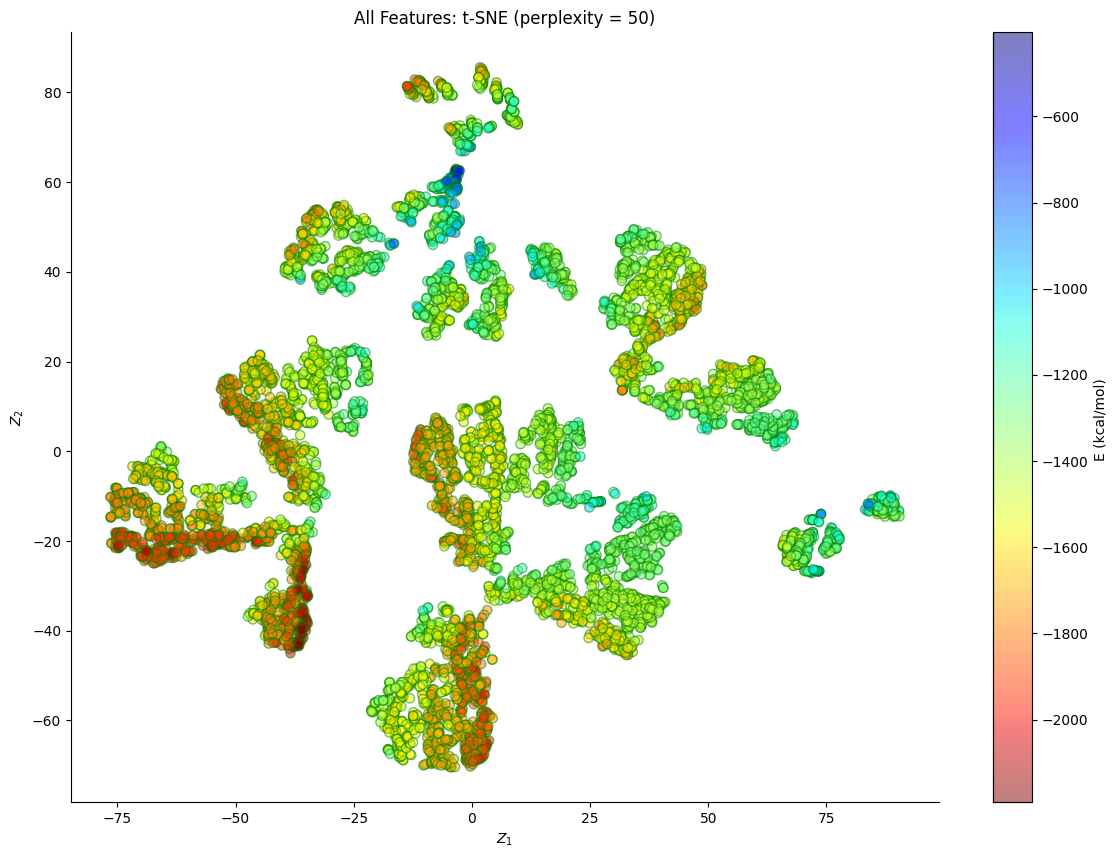

In [10]:
tsne = TSNE(n_components=2, random_state=rand_state, perplexity=50)
X_tsne = tsne.fit_transform(X)

fig = plt.figure(figsize=(14,10))
ax  = fig.add_subplot(111)

scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], c=y, s=45, edgecolors='green', cmap=cm.jet_r, alpha=0.5)
colorbar = fig.colorbar(scatter, ax=ax, label = "E (kcal/mol) ")
plt.xlabel(r'$Z_1$')
plt.ylabel(r'$Z_2$')
plt.title('All Features: t-SNE (perplexity = 50)')
sns.despine()
plt.show()

In [11]:
def get_category(x, total_range, num_bins):
    bin_size = total_range/num_bins
    total_range = 1787.119995
    bin_size = total_range/num_bins

    return int(np.floor(np.abs(x/bin_size)))

total_range = 1787.119995
num_bins = 10

y_class = pd.Series(y).apply(lambda x: get_category(x, total_range, num_bins))

# Classification  

First I will create a model to classify a given atom into one of four classes, based on atomization energy. I have manually constructed my classes so that they are roughly balanced. A tool like this can provide us insight into 'tricky' molecules, those that are difficult to distinguish among.  

I will split my data into **70/20/10** train/dev/val sets.

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

X_2, X_val, y_class_2, y_class_val = train_test_split(X, y_class.values, 
                                                    test_size=0.15, 
                                                    random_state=rand_state)

# with cross validation no need to further split the data. if not using cross validation you should do one...
X_train, X_dev, y_class_train, y_class_dev = train_test_split(X_2, y_class_2, 
                                                    test_size=0.18, 
                                                    random_state=rand_state)

clf = SVC(kernel='linear', random_state=rand_state)
clf.fit(X_train, y_class_train)
print("Train score: ", clf.score(X_train, y_class_train))
print("Test score: ", clf.score(X_dev, y_class_dev))

print('--------\nEVALUATE on validation set\n--------')
class_preds = clf.predict(X_val)
print("Validation score: ", accuracy_score(y_class_val, class_preds))
print(classification_report(y_class_val, class_preds))

Train score:  0.971159623472862
Test score:  0.9033728350045579
--------
EVALUATE on validation set
--------
Validation score:  0.9237209302325582
              precision    recall  f1-score   support

           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         3
           5       0.88      1.00      0.93        14
           6       0.87      0.87      0.87        83
           7       0.91      0.88      0.90       214
           8       0.90      0.95      0.93       318
           9       0.97      0.91      0.94       307
          10       0.93      0.97      0.94       115
          11       1.00      1.00      1.00        19
          12       1.00      1.00      1.00         1

    accuracy                           0.92      1075
   macro avg       0.94      0.96      0.95      1075
weighted avg       0.92      0.92      0.92      1075



# Regression

First, I am going to split my data into 70/15/15 train/dev/validation sets, and use 3-fold cross validation when training my model. Through experimentation (as well as previous [work](https://www.kaggle.com/mjmurphy28/predicting-ground-state-energy)) XGBoost provides excellent accuracy, while very low training time. I settled on the following hyper-parameters through intuition, literature as well as trial and error. As mentioned above, a number of the features that I engineered  solely for classification purposes do not add any explanatory power to my regression model, therefore I will only be using the unrolled Coulomb Matrix, Eigenvector centralities and Eigenvalues (of the interatomic distance matrix). 

In [18]:
import sys
!{sys.executable} -m pip install xgboost
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = np.concatenate((CM, eigs, centralities), axis=1)


# with cross validation no need to further split the data. if not using cross validation you should do one...
X_2, X_val, y_2, y_val = train_test_split(X, y, 
                                          test_size=0.15, 
                                          random_state=rand_state)

# with cross validation no need to further split the data. if not using cross validation you should do one...
X_train, X_dev, y_train, y_dev = train_test_split(X_2, y_2, 
                                                  test_size=0.18, 
                                                  random_state=rand_state)


n_folds = 5
early_stopping = 50


start_time = time.time()
xg_train = xgb.DMatrix(X_train, label=y_train)

num_iters = 300

params = {"objective":"reg:linear", 
          'booster': 'gbtree', 
          'eval_metric': 'mae',
          'subsample': 0.9,
          'colsample_bytree':0.2,
          'learning_rate': 0.05,
          'max_depth': 6, 
          'reg_lambda': .9, 
          'reg_alpha': .01,
          'seed': rand_state}



cv = xgb.cv(params,
            xg_train, 
            num_boost_round=num_iters, 
            nfold=n_folds, 
            early_stopping_rounds=early_stopping, 
            verbose_eval = 0, 
            seed=rand_state,
            as_pandas=False)

print("--- %s seconds ---" % (time.time() - start_time))

plt.figure(figsize=(8,8))
plt.plot(cv['train-mae-mean'][100:], label='Train loss: ' + str(np.min(cv['train-mae-mean'])))
plt.plot(cv['test-mae-mean'][100:], label='Test loss: ' + str(np.min(cv['test-mae-mean'])))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean absolute error')
plt.show()

model_xgb = xgb.XGBRegressor(**params, random_state=rand_state, n_estimators=num_iters)
model_xgb.fit(X_train, y_train, 
              early_stopping_rounds=early_stopping, 
              eval_metric='mae', 
              eval_set=[(X_dev, y_dev)], 
              verbose=False)

y_dev_pred = model_xgb.predict(X_dev)
print('Dev mean absoulte error: ', mean_absolute_error(y_dev, y_dev_pred))

y_val_pred = model_xgb.predict(X_val)
print('Validation mean absoulte error: ', mean_absolute_error(y_val, y_val_pred))

[19:00:48] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[19:00:52] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[19:00:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[19:01:07] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[19:01:16] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


KeyboardInterrupt: 

Note that this model (underlying data/problem) overfits badly. By adding regularization I was able to decrease the amount our model overfits to the train data. Note that if you run this model for more boosting rounds (iterations) the model begins to significantly overfit. Setting the max depth of each tree also helps reduce this.

In [ ]:
from yellowbrick.regressor import PredictionError

# Instantiate the linear model and visualizer
visualizer = PredictionError(xgb.XGBRegressor(**params, n_estimators=num_iters, random_state=rand_state))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()       

Notice the shape of the distributions, notably those belonging to class 2.

In [ ]:
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
visualizer = ResidualsPlot(xgb.XGBRegressor(**params, n_estimators=num_iters, random_state=rand_state))

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

# Deep Learning 

Translation invariance is a crucial aspect of why convnet's are so effective when dealing with images, and here I show that a similar approach can be taken when dealing with molecules; rotational-invariance is ubiquitous in chemistry. I will use both 2D and 1D convnets.  

## 1D Convolutional Neural Network  

These networks are typically used when dealing with time series (sequences), and we can view our molecule as a sequence of atoms; specifically sequences of the raw Coulomb Matrices, unraveled into row vectors.

In [ ]:
CM_scaled = (qm7['X'] / 370.0).reshape((7165, 529, 1))

# now pull out 10% of the data for validation
x_2, x_val, y_2, y_val = train_test_split(CM_scaled, y_scaled,  
                                                    test_size=.15, 
                                                    random_state=rand_state)

# the remaining 90% of the data will be used to build/test our model
x_train, x_dev, y_train, y_dev = train_test_split(x_2, y_2,  
                                                    test_size=.18, 
                                                    random_state=rand_state)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import math

model_1 = Sequential()
# our input is now a (276, 1) 1D Tensor
kernel_initializer='he_normal'

model_1.add(Conv1D(32, 10, activation='relu', kernel_initializer=kernel_initializer))
model_1.add(Conv1D(128, 7, activation='relu', kernel_initializer=kernel_initializer))
model_1.add(Conv1D(128, 5, activation='relu', kernel_initializer=kernel_initializer))
model_1.add(Conv1D(256, 3, activation='relu', kernel_initializer=kernel_initializer))
model_1.add(Flatten())
model_1.add(Dense(1, activation='linear'))

model_1.compile(loss='mae',
              optimizer=optimizers.Adam(.001),
              metrics=['mae'])



start = time.time()

estop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('cnn_1d.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, epsilon=1e-4, mode='min')

history_1 = model_1.fit(x_train, y_train,
                      batch_size=4,
                      epochs=10, 
                      callbacks=[estop, mcp_save, reduce_lr_loss],
                      verbose=1,
                      validation_data=(x_dev, y_dev))

model_1.summary()

end = time.time()
print('Execution time: ', end-start)
print("Epochs: ", len(history_1.history['val_loss']))
print('Train loss: ', y_scaling_factor*np.min(history_1.history['loss']))
print('Test loss: ', y_scaling_factor*np.min(history_1.history['val_loss']))
y_preds = model_1.predict(x_val)
print("Validation error: ", y_scaling_factor*mean_absolute_error(y_val, y_preds))

In [ ]:
plt.figure(figsize=(8,8))
train_label = "Train loss: {}".format(np.round(np.min(history_1.history['loss'])*y_scaling_factor, 3))
test_label = "Test loss: {}".format(np.round(np.min(history_1.history['val_loss'])*y_scaling_factor, 3))
(pd.Series(history_1.history['loss']).ewm(alpha=.1).mean()*y_scaling_factor).plot(label=train_label)
(pd.Series(history_1.history['val_loss']).ewm(alpha=.1).mean()*y_scaling_factor).plot(label=test_label)
plt.legend()
plt.title('MAE Loss for 1D CNN')
plt.xlabel('Epoch')
plt.ylabel('E (kcal/mol)')
plt.show()

## 2D Convolutional Neural Network  

This type of network operates on matrix input, so raw Coulomb Matrices seem natural. Convnets essentially eliminate feature engineering, however, the choice of network topology, filters and optimizers (as well as other things) play a crucial role in the performance (and training) of the network.

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Dropout


'''
convnets require specific input dimensions, in this case every example should be a (23, 23, 1) Coulom Matrix

'''
CM_scaled = qm7['X'].reshape((7165, 23, 23, 1)) / 370.0

X_cm_train, X_cm_test, y_train, y_test  = train_test_split(CM_scaled, y_scaled, 
                                                           test_size=.2, random_state=rand_state)

kernel_initializer='he_normal'
model_2 = Sequential()
model_2.add(Conv2D(32, kernel_size=(7,7), padding='same',
                 activation='relu',
                 kernel_initializer=kernel_initializer,
                 input_shape=(23, 23, 1)))
model_2.add(Conv2D(64, kernel_size=(5,5), kernel_initializer=kernel_initializer, activation='relu'))
model_2.add(Conv2D(64, kernel_size=(3,3), kernel_initializer=kernel_initializer, activation='relu'))
model_2.add(Conv2D(64, kernel_size=(3,3), kernel_initializer=kernel_initializer, activation='relu'))
model_2.add(Conv2D(128, kernel_size=(3,3), kernel_initializer=kernel_initializer, activation='relu'))
model_2.add(Conv2D(128, kernel_size=(3,3), kernel_initializer=kernel_initializer, activation='relu'))
model_2.add(Flatten())
model_2.add(Dense(1, activation='linear'))

model_2.compile(loss='mae',
              optimizer=optimizers.Adam(lr=.001),
              metrics=['mae'])

start = time.time()


estop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('cnn_2d.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, epsilon=1e-4, mode='min')

history_2 = model_2.fit(X_cm_train, y_train,
                      batch_size=4,
                      epochs=10, 
                      callbacks=[estop, mcp_save, reduce_lr_loss],
                      verbose=1,
                      validation_data=(X_cm_test, y_test))

end = time.time()

print(model_2.summary())

print('Execution time: ', end-start)
print("Epochs: ", len(history_2.history['val_loss']))
print('Train loss: ', y_scaling_factor*np.min(history_2.history['loss']))
print('Test loss: ', y_scaling_factor*np.min(history_2.history['val_loss']))

In [ ]:
plt.figure(figsize=(8,8))
train_label = "Train loss: {}".format(np.round(np.min(history_2.history['loss'])*y_scaling_factor, 3))
test_label = "Test loss: {}".format(np.round(np.min(history_2.history['val_loss'])*y_scaling_factor, 3))
(pd.Series(history_2.history['loss']).ewm(alpha=.1).mean()*y_scaling_factor).plot(label=train_label)
(pd.Series(history_2.history['val_loss']).ewm(alpha=.1).mean()*y_scaling_factor).plot(label=test_label)
plt.legend()
plt.title('MAE Loss for 2D CNN')
plt.xlabel('Epoch')
plt.ylabel('E (kcal/mol)')
plt.show()

# Conclusion  


# References  

  * https://papers.nips.cc/paper/4830-learning-invariant-representations-of-molecules-for-atomization-energy-prediction.pdf
  * Rupp, Matthias, et al. "Fast and accurate modeling of molecular atomization energies with machine learning." Physical review letters 108.5 (2012): 058301.
  * Montavon, Grégoire, et al. ["Learning invariant representations of molecules for atomization energy prediction."](https://pdfs.semanticscholar.org/5761/d22bb67798167a832879a473e0ece867df04.pdf) Advances in Neural Information Processing Systems. 2012.
  